### Dataset

#### experimental structure
5 runs <br>
12 trials per run <br>
4 conditions 
- cond 1: low GO, low U
- cond 2: low GO, high U
- cond 3: high GO, low U
- cond 4: high GO, high U <br>

No_subs = 49

No_conditions = 6 <br>
6 types of events per trial <br>
list of conditions: 'caught', 'chase', 'checkpoint', 'close_enemy', 'protected_by_wall', 'vc_hit' <br>

#### possibilities of modelling data per sub
- __one beta map per run__
- one beta map per x trials, x={1,2,3,6}
- one beta map per condition --> we will model conditions rather than the events within a trial

#### tutorial link
https://peerherholz.github.io/workshop_weizmann/advanced/machine_learning_nilearn.html

In [9]:
import nibabel as nib
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA


from nilearn.maskers import NiftiMasker
from nilearn.masking import compute_brain_mask
from nilearn.image import math_img
from nilearn.plotting import plot_stat_map
from nilearn.plotting import plot_roi

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from function import *

# Data Loading and Visualization

In [10]:
# load beta images
# And clean them, replacing nans by 0s ...
from nilearn.image import clean_img
beta_maps_dir = 'data/beta_maps'
beta_maps = []
for file in sorted(os.listdir(beta_maps_dir)):
    if file.endswith('.nii.gz'):
        map = nib.load(os.path.join(beta_maps_dir, file))
        beta_maps.append(clean_img(map, standardize=False, ensure_finite=True))

nb_sub = len(beta_maps)

print('Number of subjects: ', nb_sub)

Number of subjects:  49


## Creation of the mask

Shape of the mask:  (91, 109, 91)


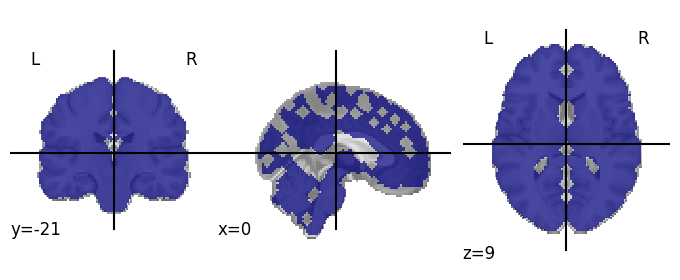

In [11]:
anat_path = 'data/anatomy/mask.nii'
anatomy = nib.load(anat_path)
mask = compute_brain_mask(anatomy)

print('Shape of the mask: ', mask.shape)
plot_roi(mask)

## Masking the data

In [12]:
masker = NiftiMasker(mask_img=mask)

samples = []
for map in tqdm(beta_maps):
    samples.append(masker.fit_transform(map))
samples = np.concatenate(samples, axis=0)

100%|██████████| 49/49 [00:29<00:00,  1.68it/s]


In [13]:
print("We have 49 subjects, and for each of them there are 30 beta maps. Hence we have", samples.shape[0],
      "observations and",  samples.shape[1], "features")

We have 49 subjects, and for each of them there are 30 beta maps. Hence we have 1470 observations and 216734 features


## Labels 

In [14]:
labels = np.tile(['caught', 'chase', 'checkpoint', 'close_enemy', 'protected_by_wall', 'vc_hit'], 5*nb_sub)
print('Numbers of labels/training samples: ', len(labels))

Numbers of labels/training samples:  1470


# Classification

- Baseline model with original dataset
- Tuned Model with features extraction (PCA)
- SpaceNet 


    
https://www.cs.purdue.edu/homes/jhonorio/fmrisynth_bookchapter14.pdf


## Baseline

In order to estimate the generalization accuracy of the classifiers : 

• k-fold cross-validation. We hold out S/k samples in turn while training
on the other S(k − 1)/k samples. The held out samples are used for
measuring the classification accuracy.

• Independent set. After training in the whole dataset of  samples,
we measure the classification accuracy in an independent set of 4 subject (20 samples).

### Cross Validation strategies

- 5-fold CV
- leave 1 run out across all subjects
- (run a model per sub, leave 1 run out within subject)

In [15]:
np.random.seed(4)
chunks_CV = {}
for key in ['per_7subjects', 'per_run'] :
    chunks_CV[key]=eval('make_chunks_'+key)(49)
    
classifiers = {'Ridge' :RidgeClassifier(),  'GaussianNB' : GaussianNB(), 'RandomForest' : RandomForestClassifier() }
dic_cv_scores={}

In [16]:
for name, clf in classifiers.items() : 
    print('\n'+ name + ', 5fold CV :')
    cv_scores=cross_val_score(estimator=clf,
                            X=samples,
                            y=labels,
                            cv=5,
                            n_jobs=1,
                            verbose=1)
    
    dic_cv_scores[name+'5FCV'] = cv_scores.mean()
    
    #print score per fol & the mean of it
    print('Average accuracy = %.02f percent\n' % (cv_scores.mean() * 100))
    print('Accuracy per fold:', cv_scores, sep='\n')
    
    
    for key, chunk in chunks_CV.items() : 
        print('\n'+ name + ','+ key + ' :' )
        cv_scores = cross_val_score(estimator=clf,
                            X=samples,
                            y=labels,
                            groups=chunk,
                            cv=LeaveOneGroupOut(),
                            n_jobs=1,
                            verbose=1)
        
        dic_cv_scores[name+'_'+key]= cv_scores.mean()
        
        #print score per fol & the mean of it
        print('Average accuracy = %.02f percent\n' % (cv_scores.mean() * 100))
        print('Accuracy per fold:', cv_scores, sep='\n')


Ridge, 5fold CV :


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/skowronski/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.44461e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/skowronski/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.94565e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/skowronski/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.90293e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/skowronski/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using le

Average accuracy = 61.50 percent

Accuracy per fold:
[0.54761905 0.59863946 0.65646259 0.63945578 0.63265306]

Ridge,per_7subjects :


/Users/skowronski/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.14341e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/skowronski/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.36792e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/skowronski/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.89185e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/skowronski/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.30527e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwri

Average accuracy = 61.84 percent

Accuracy per fold:
[0.52857143 0.6047619  0.62380952 0.67619048 0.58095238 0.68095238
 0.63333333]

Ridge,per_run :


/Users/skowronski/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/skowronski/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/skowronski/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/skowronski/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/skowronski/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares 

Average accuracy = 67.28 percent

Accuracy per fold:
[0.63945578 0.69047619 0.47278912 0.74829932 0.81292517]

GaussianNB, 5fold CV :


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   40.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Average accuracy = 70.88 percent

Accuracy per fold:
[0.60204082 0.72789116 0.7414966  0.73469388 0.73809524]

GaussianNB,per_7subjects :


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   49.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Average accuracy = 73.27 percent

Accuracy per fold:
[0.7047619  0.76190476 0.75714286 0.75238095 0.71428571 0.7
 0.73809524]

GaussianNB,per_run :


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   40.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Average accuracy = 72.86 percent

Accuracy per fold:
[0.6462585  0.74489796 0.73129252 0.75170068 0.76870748]

RandomForest, 5fold CV :


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Average accuracy = 79.86 percent

Accuracy per fold:
[0.78571429 0.77210884 0.81292517 0.81292517 0.80952381]

RandomForest,per_7subjects :


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  4.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Average accuracy = 79.12 percent

Accuracy per fold:
[0.74761905 0.83809524 0.76190476 0.83333333 0.81428571 0.77619048
 0.76666667]

RandomForest,per_run :
Average accuracy = 80.61 percent

Accuracy per fold:
[0.7414966  0.79931973 0.80952381 0.85034014 0.82993197]


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.6min finished


### Independent set

In [17]:
nb_test = 4
test_samples = samples[0:nb_test*30,:]
train_samples = samples[nb_test*30:nb_sub*30,:]

test_labels = labels[0:nb_test*30]
train_labels = labels[nb_test*30:nb_sub*30]

In [18]:
for name, clf in classifiers.items() : 
    print('\n'+ name )
    
    clf.fit(train_samples, train_labels)
    train_error = clf.score(train_samples, train_labels)
    condition_pred=clf.predict(test_samples)
    test_error = accuracy(test_labels, condition_pred)
    

    #print score per fold & the mean of it
    print('Train accuracy : ', train_error)
    print('Test accuracy :',  test_error)


Ridge


/Users/skowronski/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.25389e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


Train accuracy :  0.9977777777777778
Test accuracy : 0.575

GaussianNB
Train accuracy :  0.7814814814814814
Test accuracy : 0.6416666666666667

RandomForest
Train accuracy :  1.0
Test accuracy : 0.775


## Tuned Model with or without features extraction

- Tunning without PCA 
- PCA & Tunning

In [19]:
def run_1(pipeline, grid, name_clf, type_) :
    
    print('\n'+ name_clf + ', 5fold CV : \n')
    
    ## n_jobs to 1 other wise it crashes :(
    grid_result = GridSearchCV(pipeline, param_grid = grid, scoring = 'accuracy', verbose=1, n_jobs=1, cv = 5)
    grid_result.fit(samples, labels)
    
    print('Mean test score :' , grid_result.cv_results_['mean_test_score'], '\n')
    print(' Test score std  :', grid_result.cv_results_['std_test_score'], '\n')
    
    print('Best Score: ', grid_result.best_score_) 
    print('Best Params: ', grid_result.best_params_) 
    dic_cv_scores[name_clf+'_5FCV_'+type_]=(grid_result.best_score_)
    
    for key, chunk in chunks_CV.items():
        print('\n'+name_clf+ ' , ' +  key +' : \n')
        
        grid_result = GridSearchCV(pipeline, param_grid = grid, scoring = 'accuracy', verbose=1, n_jobs=1, cv = LeaveOneGroupOut() )
        grid_result.fit(samples, labels, groups = chunk)
        
        print('Mean test score :' , grid_result.cv_results_['mean_test_score'], '\n')
        print(' Test score std  :', grid_result.cv_results_['std_test_score'], '\n')
    
              
        dic_cv_scores[name_clf+'_'+key+type_]= grid_result.best_score_
        print('Best Score: ', grid_result.best_score_) #Mean cross-validated score of the best_estimator
        print('Best Params: ', grid_result.best_params_) 

### Cross Validation strategies

- 5-fold CV
- leave 1 run out across all subjects
- leave a set of subject (7*9) across all subject 

### Tunning without PCA

*NB*:  var_smoothing is a stability calculation to widen (or smooth) the curve and therefore account for more samples that are further away from the distribution mean. In this case, np.logspace returns numbers spaced evenly on a log scale, starts from 0, ends at -9, and generates 25 samples. 

In [20]:
grid_ridge = {'Ridge__alpha': [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1] }
# Here changed tje num to 10 insteal of 25 to speed things up
grid_GaussianNB = {'GaussianNB__var_smoothing': np.logspace(0,-9, num=10)} 

grid_Forest = {'RandomForest__max_depth' :[int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]}

In [21]:
for name, clf in classifiers.items():
    
    if (name=='Ridge'): param_grid = grid_ridge
    if (name=='GaussianNB'): param_grid = grid_GaussianNB
    if(name=='RandomForest') : param_grid = grid_Forest 
    
    
    pipe = Pipeline([(name ,clf)])
    
    run_1(pipe, param_grid, name, '_Tuned')


Ridge, 5fold CV : 

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/skowronski/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/skowronski/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/skowronski/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/skowronski/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/skowronski/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares 

Mean test score : [0.61632653 0.61632653 0.61632653 0.61496599 0.61428571 0.61496599] 

 Test score std  : [0.03722276 0.03722276 0.03722276 0.03796138 0.03839773 0.03856609] 

Best Score:  0.616326530612245
Best Params:  {'Ridge__alpha': 1e-05}

Ridge , per_7subjects : 

Fitting 7 folds for each of 6 candidates, totalling 42 fits


/Users/skowronski/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/skowronski/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/skowronski/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/skowronski/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/skowronski/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares 

Mean test score : [0.62176871 0.62176871 0.62176871 0.62176871 0.62244898 0.61836735] 

 Test score std  : [0.0498691  0.0498691  0.0498691  0.0498691  0.04959925 0.04951521] 

Best Score:  0.6224489795918368
Best Params:  {'Ridge__alpha': 0.1}

Ridge , per_run : 

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/skowronski/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/skowronski/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/skowronski/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/skowronski/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/skowronski/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares 

Mean test score : [0.67142857 0.67142857 0.67210884 0.67210884 0.67278912 0.67278912] 

 Test score std  : [0.11597792 0.11597792 0.11575825 0.11575825 0.11555419 0.11555419] 

Best Score:  0.6727891156462584
Best Params:  {'Ridge__alpha': 0.1}

GaussianNB, 5fold CV : 

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mean test score : [0.18639456 0.28911565 0.58163265 0.70544218 0.72176871 0.72312925
 0.7170068  0.71496599 0.70884354 0.70884354] 

 Test score std  : [0.01629816 0.04126735 0.07559902 0.04453575 0.03974792 0.03590651
 0.03747058 0.0414017  0.05359059 0.05359059] 

Best Score:  0.7231292517006802
Best Params:  {'GaussianNB__var_smoothing': 1e-05}

GaussianNB , per_7subjects : 

Fitting 7 folds for each of 10 candidates, totalling 70 fits
Mean test score : [0.18707483 0.29319728 0.57346939 0.70612245 0.73333333 0.73537415
 0.73265306 0.73265306 0.73265306 0.73265306] 

 Test score std  : [0.01563146 0.04692398 0.04747305 0.02342745 0.02114322 0.02581451
 0.024

### Tunning with PCA 

In [22]:
for name, clf in classifiers.items():
    
    if (name=='Ridge'): param_grid = grid_ridge
    if (name=='GaussianNB'): param_grid = grid_GaussianNB
    if(name=='RandomForest') : param_grid = grid_Forest 
    
    pipe = Pipeline([('scale', MinMaxScaler()), ('pca' , PCA(n_components=150)), (name ,clf)])
    
    run_1(pipe, param_grid, name, '_PCA_tuned')


Ridge, 5fold CV : 

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Mean test score : [0.77142857 0.77414966 0.76802721 0.77210884 0.77006803 0.76870748] 

 Test score std  : [0.03258212 0.03412228 0.03383627 0.03004    0.03209558 0.03387728] 

Best Score:  0.7741496598639455
Best Params:  {'Ridge__alpha': 0.0001}

Ridge , per_7subjects : 

Fitting 7 folds for each of 6 candidates, totalling 42 fits
Mean test score : [0.77142857 0.76802721 0.76870748 0.76462585 0.76734694 0.76802721] 

 Test score std  : [0.0587087  0.05349552 0.05077036 0.05045033 0.052869   0.05498855] 

Best Score:  0.7714285714285714
Best Params:  {'Ridge__alpha': 1e-05}

Ridge , per_run : 

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Mean test score : [0.76258503 0.77278912 0.76598639 0.76666667 0.7707483  0.76870748] 

 Test score std  : [0.05701313 0.04860019 0.04845715 0.0523677  0.04735593 0.04648803] 

Best Score:  0.7727891156462585
Best Params:  {'Ridge__alpha': 0.0001}

Gaussia

In [23]:
for model, score in  dic_cv_scores.items():
    print ('- ', model, ' : ' , score, '\n')

-  Ridge5FCV  :  0.6149659863945578 

-  Ridge_per_7subjects  :  0.6183673469387756 

-  Ridge_per_run  :  0.6727891156462584 

-  GaussianNB5FCV  :  0.708843537414966 

-  GaussianNB_per_7subjects  :  0.7326530612244898 

-  GaussianNB_per_run  :  0.7285714285714286 

-  RandomForest5FCV  :  0.7986394557823129 

-  RandomForest_per_7subjects  :  0.791156462585034 

-  RandomForest_per_run  :  0.8061224489795918 

-  Ridge_5FCV__Tuned  :  0.616326530612245 

-  Ridge_per_7subjects_Tuned  :  0.6224489795918368 

-  Ridge_per_run_Tuned  :  0.6727891156462584 

-  GaussianNB_5FCV__Tuned  :  0.7231292517006802 

-  GaussianNB_per_7subjects_Tuned  :  0.735374149659864 

-  GaussianNB_per_run_Tuned  :  0.7326530612244898 

-  RandomForest_5FCV__Tuned  :  0.7979591836734694 

-  RandomForest_per_7subjects_Tuned  :  0.8006802721088435 

-  RandomForest_per_run_Tuned  :  0.8142857142857143 

-  Ridge_5FCV__PCA_tuned  :  0.7741496598639455 

-  Ridge_per_7subjects_PCA_tuned  :  0.771428571428571

# SpaceNet : SpaceNet: decoding with spatial structure for better maps

# Searchlight :  
small group of neighboring features is extracted from the data, and the prediction function is instantiated on these features only. The resulting prediction accuracy is thus associated with all the features within the group, or only with the feature on the center. This yields a map of local fine-grained information, that can be used for assessing hypothesis on the local spatial layout of the neural code under investigation

In [24]:
# Because it takes a while to run, we'll take one subject for testing and 5 for training.
beta_maps_test = beta_maps[0]
beta_maps_train = nib.funcs.concat_images(beta_maps[1:6], axis = -1)
labels_test = labels[:30]
labels_train = labels[30:150+30]

In [25]:
from nilearn.decoding import SpaceNetClassifier
decoder = SpaceNetClassifier(penalty='tv-l1',
                             mask=mask,
                             max_iter=10, # We need to change this to 1000 but even 10 takes a lot of time
                             cv=5,
                             standardize=True,
                             memory="nilearn_cache",
                             memory_level=2,
                             verbose=1)

# We need to input 4D images to decoder.fit but we input a list of 4D images. I couldn't find a solution online :(
# I didn't use train_samples and train_labels beacuse decoder.fit wants NIFTI images
decoder.fit(beta_maps_train, labels_train)

[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


Time Elapsed: 13.8769 seconds, 0 minutes.


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   11.8s finished


SpaceNetClassifier(cv=5,
                   mask=<nibabel.nifti1.Nifti1Image object at 0x1315ba0a0>,
                   max_iter=10, memory=Memory(location=nilearn_cache/joblib),
                   memory_level=2, penalty='tv-l1')

In [26]:
# Prediction
test_pred = decoder.predict(beta_maps_test)
# Return average accuracy
accuracy = (test_pred == labels_test).mean() * 100.
print("\nTV-l1  classification accuracy : %g%%" % accuracy)

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(91, 109, 91, 30),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals

TV-l1  classification accuracy : 43.3333%


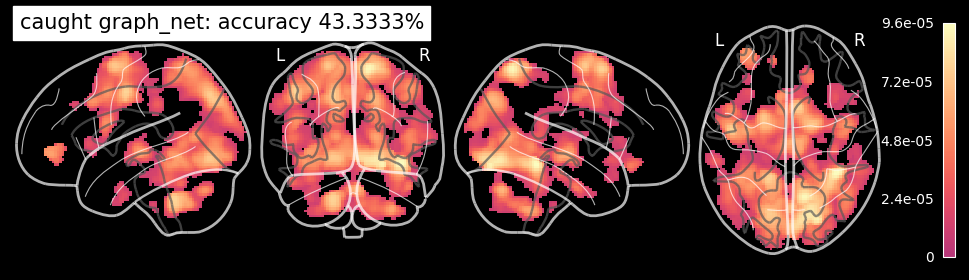

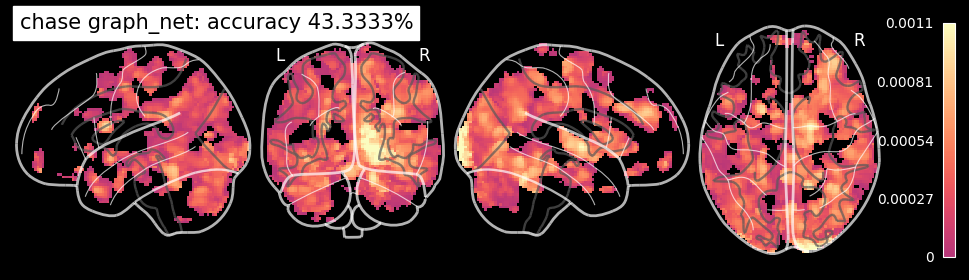

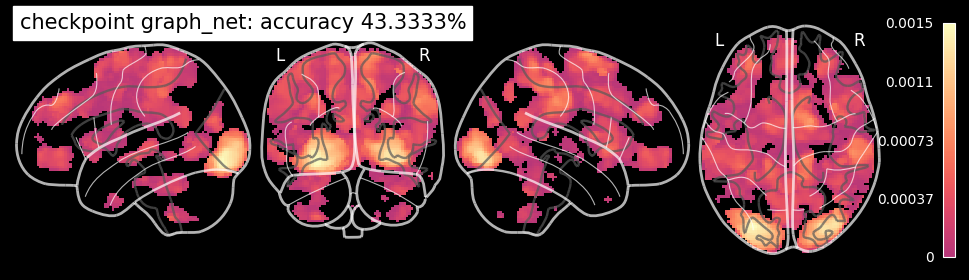

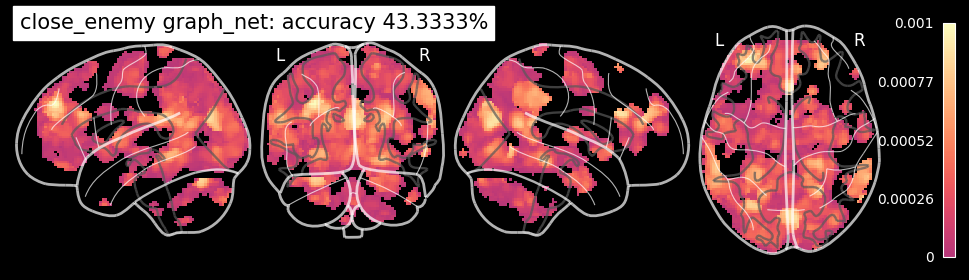

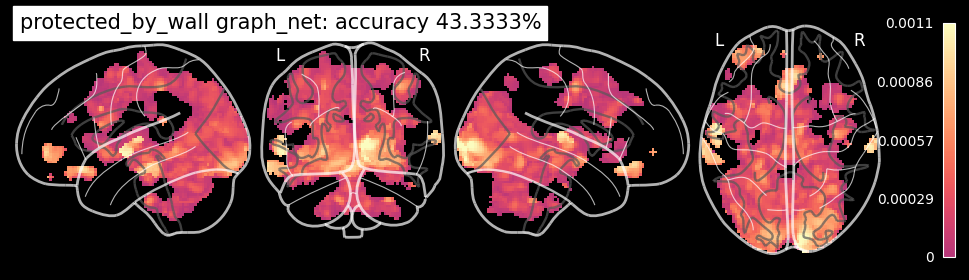

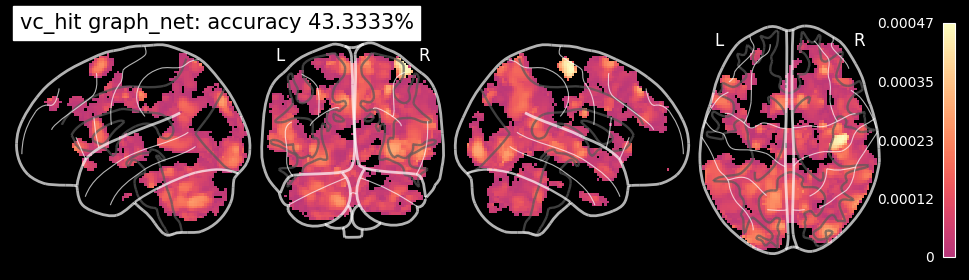

In [27]:
from nilearn.plotting import plot_stat_map, show
coef_img = decoder.coef_img_
# Plotting the searchlight results on the glass brain
from nilearn.plotting import plot_glass_brain
conditions = ['caught', 'chase', 'checkpoint', 'close_enemy', 'protected_by_wall', 'vc_hit']
for i, condition in enumerate(conditions):
    plot_glass_brain(coef_img.slicer[...,i], black_bg=True, colorbar=True, display_mode='lyrz', symmetric_cbar=False,
                 cmap='magma', title=condition + ' graph_net: accuracy %g%%' % accuracy)

In [28]:
from nilearn.decoding import SearchLight
from nilearn.image import new_img_like
from nilearn.plotting import plot_glass_brain

In [29]:
sphere_radius = 8  # in mm

In [30]:
## Searchlight but without folds to start
## No cv because error with the groups if we put cv=LeaveOneGroupOut()

sl = SearchLight(mask,
                 process_mask_img=mask,
                 radius=sphere_radius,
                 estimator=GaussianNB(),
                 n_jobs=1,
                 verbose=1,)

sl.fit(beta_maps_train, labels_train)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/skowronski/Library/Python/3.9/lib/python/site-packages/sklearn/naive_bayes.py:487: RuntimeWarning: divide by zero encountered in log
  n_ij = -0.5 * np.sum(np.log(2.0 * np.pi * self.var_[i, :]))
/Users/skowronski/Library/Python/3.9/lib/python/site-packages/sklearn/naive_bayes.py:488: RuntimeWarning: divide by zero encountered in divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
/Users/skowronski/Library/Python/3.9/lib/python/site-packages/sklearn/naive_bayes.py:488: RuntimeWarning: invalid value encountered in divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
/Users/skowronski/Library/Python/3.9/lib/python/site-packages/sklearn/naive_bayes.py:487: RuntimeWarning: divide by zero encountered in log
  n_ij = -0.5 * np.sum(np.log(2.0 * np.pi * self.var_[i, :]))
/Users/skowronski/Library/Python/3.9/lib/python/site-packages/sklearn/naiv

SearchLight(estimator=GaussianNB(),
            mask_img=<nibabel.nifti1.Nifti1Image object at 0x1315ba0a0>,
            process_mask_img=<nibabel.nifti1.Nifti1Image object at 0x1315ba0a0>,
            radius=8, verbose=1)

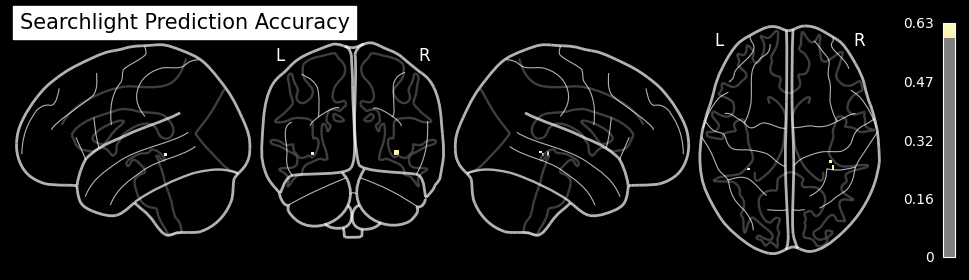

In [31]:
# First we need to put the searchlight output back into an MRI image
from nilearn.image import new_img_like
from nilearn.plotting import plot_glass_brain
searchlight_img = new_img_like(beta_maps_train, sl.scores_)
plot_glass_brain(searchlight_img, black_bg=True, colorbar=True, display_mode='lyrz',
                 threshold=0.6, cmap='magma', title='Searchlight Prediction Accuracy')

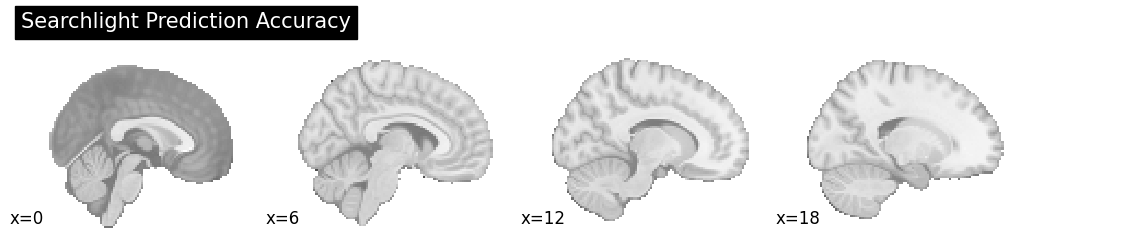

In [32]:
from nilearn.plotting import plot_stat_map
plot_stat_map(searchlight_img, cmap='magma', colorbar=True,
              display_mode='x', threshold=0.6, cut_coords=[0, 6, 12, 18],
              title='Searchlight Prediction Accuracy');